In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras
from keras.models import Sequential
import keras.layers as tfl
from sklearn.model_selection import train_test_split

# **Load the input and output datasets**


In [2]:
path_dir: str = r"/content"

feature_descriptors_path = os.path.join(path_dir, 
                                        'hog_feature_descriptors.csv')
camera_settings_path = os.path.join(path_dir, 'camera_settings.csv')

# read the input, output datasets
df1 = pd.read_csv(feature_descriptors_path)
df2 = pd.read_csv(camera_settings_path)

# **Feature Scaling**

In [144]:
def feature_scaling(df):
  #copy the dataframe
  df_new = df.copy()
  # create a dictionary to store mean, max, min of each column
  stats = {}

  for column in df_new.columns:
    temp_dict = {"mean":df_new[column].mean(), "max":df_new[column].max(), 
              "min":df_new[column].min()}

    if temp_dict["max"] != temp_dict["min"]:
      df_new[column] = (df_new[column] - temp_dict["mean"]) / (temp_dict["max"] - temp_dict["min"])
    else:
      df_new[column] = df_new[column]/temp_dict["mean"]
    stats[column] = temp_dict

  return df_new, stats

In [145]:
df1_scaled, stats1 = feature_scaling(df1.drop('hog_input_img', axis = 1))
df1_scaled

,0-20,20-40,40-60,60-80,80-100,100-120,120-140,140-160,160-180
0,0.500312,0.451862,-0.217857,-0.124985,0.051517,-0.014105,-0.262228,0.039518,0.040515
1,0.458506,0.362611,-0.208614,-0.079560,0.079116,-0.048411,-0.310835,0.003673,0.231259
2,0.393571,0.393159,-0.185922,-0.080907,0.084444,-0.114641,-0.331556,0.019396,0.178675
3,0.336407,0.290615,-0.152262,-0.063119,0.044170,-0.109702,-0.373299,0.169017,0.084332
4,0.315061,0.222008,-0.133600,-0.032582,0.060206,-0.174535,-0.377369,0.078288,0.222786
...,...,...,...,...,...,...,...,...,...
74995,-0.113583,-0.153366,0.004781,-0.051849,-0.097730,0.113376,0.189425,-0.210674,-0.188817
74996,-0.134770,-0.126703,0.029232,-0.021334,-0.092263,0.141500,0.173181,-0.200838,-0.180407
74997,-0.104503,-0.135287,0.072452,-0.040298,-0.047574,0.063080,0.181744,-0.235010,-0.168999
74998,-0.086767,-0.140075,0.060863,0.003088,-0.080385,0.023881,0.144815,-0.171475,-0.119309


In [249]:
df2_scaled, stats2 = feature_scaling(df2.drop('hog_input_img', axis = 1))
df2_scaled

,rotXdeg,rotYdeg,rotZdeg,distX,distY,distZ,f
0,-0.5,1.0,-0.5,-0.5,-0.5,-0.5,-0.500000
1,-0.5,1.0,-0.5,-0.5,-0.5,-0.5,-0.388889
2,-0.5,1.0,-0.5,-0.5,-0.5,-0.5,-0.277778
3,-0.5,1.0,-0.5,-0.5,-0.5,-0.5,-0.166667
4,-0.5,1.0,-0.5,-0.5,-0.5,-0.5,-0.055556
...,...,...,...,...,...,...,...
74995,0.5,1.0,0.5,0.5,0.5,0.5,0.055556
74996,0.5,1.0,0.5,0.5,0.5,0.5,0.166667
74997,0.5,1.0,0.5,0.5,0.5,0.5,0.277778
74998,0.5,1.0,0.5,0.5,0.5,0.5,0.388889


# **Train, validation and test datasets**

In [250]:
# input data (HOG features)
X = df1_scaled.values

# output data (camera settings)
y = df2_scaled.values

# split data into training and testing data
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size = 0.2, 
                                                    random_state = 42)

X_dev, X_test, y_dev, y_test = train_test_split(X_temp, y_temp, test_size = 0.5, 
                                                random_state = 42)

# **DNN model**

In [189]:
#@title deep NN model
def dnn_model(n_inputs, n_outputs, alpha, hidden_units_3):
  model = Sequential()
  model.add(tfl.Dense(12, input_dim = n_inputs, kernel_initializer='he_uniform', 
                  activation='relu'))
  model.add(tfl.Dense(9, kernel_initializer='he_uniform', activation='relu'))
  model.add(tfl.Dense(hidden_units_3, kernel_initializer='he_uniform', activation='relu'))
  model.add(tfl.Dense(n_outputs, activation='linear'))

  opt = keras.optimizers.Adam(learning_rate = alpha)
  model.compile(loss='mae', optimizer = opt)

  print(model.summary())

  return model

In [149]:
#@title train the dnn model
def fit_dnn_model(X_train, y_train, X_dev, y_dev, alpha=1e-1, batch_size=64,
                 epochs=1, hidden_units_3=9):
  # dimensions of the input, output
  n_inputs, n_outputs = X_train.shape[1], y_train.shape[1]

  # fit a deep learning model
  model = dnn_model(n_inputs, n_outputs, alpha, hidden_units_3)
  history = model.fit(X_train, y_train, validation_data = (X_dev, y_dev), 
                      batch_size=batch_size, epochs=epochs, verbose=1)
  return model, history

# **Train the model**

In [ ]:
model, history = fit_dnn_model(X_train, y_train, X_dev, y_dev, alpha=0.0143, 
                               batch_size=512, epochs=100, hidden_units_3=9)

# **Plot: Cost Function vs epochs**

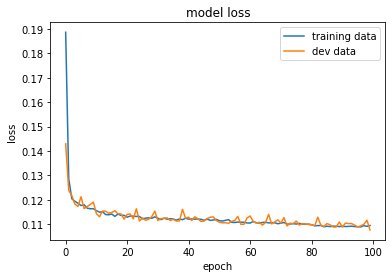

In [252]:
#@title plot cost wrt epochs
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# plt.ylim(0, 1)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training data', 'dev data'], loc='upper right')
plt.show()

In [253]:
# evaluate model on test set
mae = model.evaluate(X_test, y_test, verbose=1)
print('>%.3f' % mae)

235/235 [==============================] - 0s 2ms/step - loss: 0.1084
>0.108


# **Prediction**

In [202]:
def true_prediction(yhat,stats2):
  rotX_pred = yhat[0]*(stats2['rotXdeg']['max']-stats2['rotXdeg']['min'])+stats2['rotXdeg']['mean']
  rotY_pred = yhat[1]*(stats2['rotYdeg']['max']-stats2['rotYdeg']['min'])+stats2['rotYdeg']['mean']
  rotZ_pred = yhat[2]*(stats2['rotZdeg']['max']-stats2['rotZdeg']['min'])+stats2['rotZdeg']['mean']
  distX_pred = yhat[3]*(stats2['distX']['max']-stats2['distX']['min'])+stats2['distX']['mean']
  distY_pred = yhat[4]*(stats2['distY']['max']-stats2['distY']['min'])+stats2['distY']['mean']
  distZ_pred = yhat[5]*(stats2['distZ']['max']-stats2['distZ']['min'])+stats2['distZ']['mean']
  f_pred = yhat[6]*(stats2['f']['max']-stats2['f']['min'])+stats2['f']['mean']

  true_pred = np.array([rotX_pred, rotY_pred, rotZ_pred, distX_pred, distY_pred, distZ_pred, f_pred])

  return true_pred

In [254]:
index = 2000
if index < len(X_test):
  newX = np.asarray([X_test[index]])
  yhat = model.predict(newX)
  print("========================================================================================")
  print("True Prediction of y_hat = %s"% np.round(true_prediction(yhat[0],stats2),2))
  print("========================================================================================")
  print("True Prediction of ytest = %s"% true_prediction(y_test[index],stats2))
  print("========================================================================================")
else:
  print("Index out of range; Max value allowed is %s"%(len(X_test)-1))

True Prediction of y_hat = [  12.91   90.    131.69  452.01   88.81  886.   3804.77]
True Prediction of ytest = [  13.   90.  131.  460.   89.  910. 3900.]


# **Plot: y_hat vs y_test**

In [196]:
def true_prediction_vec(yhat,stats2):
  yhat[0] = yhat[0]*(stats2['rotXdeg']['max']-stats2['rotXdeg']['min'])+stats2['rotXdeg']['mean']
  yhat[1] = yhat[1]*(stats2['rotYdeg']['max']-stats2['rotYdeg']['min'])+stats2['rotYdeg']['mean']
  yhat[2] = yhat[2]*(stats2['rotZdeg']['max']-stats2['rotZdeg']['min'])+stats2['rotZdeg']['mean']
  yhat[3] = yhat[3]*(stats2['distX']['max']-stats2['distX']['min'])+stats2['distX']['mean']
  yhat[4] = yhat[4]*(stats2['distY']['max']-stats2['distY']['min'])+stats2['distY']['mean']
  yhat[5] = yhat[5]*(stats2['distZ']['max']-stats2['distZ']['min'])+stats2['distZ']['mean']
  yhat[6] = yhat[6]*(stats2['f']['max']-stats2['f']['min'])+stats2['f']['mean']
  return yhat

In [255]:
newX = np.asarray(X_test)
yhat = model.predict(newX)
y_hat = np.round(true_prediction_vec(yhat,stats2),2)
y_test_2 = np.round(true_prediction_vec(y_test,stats2),2)

In [219]:
column_names = df2.columns

In [ ]:
for index in range(y_test_2.shape[1]):
  plt.scatter(y_test_2[:][index], y_hat[:][index])
  plt.ylabel("y_hat")
  plt.xlabel("y_test")
  plt.title(" y_test Vs. y_hat for %s"% column_names[index+1])
  plt.show()